# Метрическая классификация. Метод ближайших соседей и его развитие
# Практическая работа

## Цели практической работы
Научиться:
- строить модель методом ближайших соседей на реальных данных;
- правильно определять качество работы модели.


## Что входит в практическую работу


- Загрузить данные и ознакомиться с ними.
- Изучить данные и провести анализ.
- Разделить данные на обучающую и тестовую выборки.
- Реализовать построение модели с помощью  библиотеки Scikit-learn.
- Подобрать оптимальное число ближайших соседей методом leave-one-out.
- Получить качество модели с помощью F-меры и матрицы сопряжённости.

## Что оценивается

1. Выполнение всех этапов работы.
2. Наличие вывода по результатам.
3. Непереобученность модели.
4. Качество модели.


**Как отправить работу на проверку?**

1. Скачайте файл с заданием в материалах, откройте его через Jupyter Notebook и выполните задачу. 
2. Сохраните изменения при помощи опции Save and Checkpoint из вкладки File или кнопки Save and Checkpoint на панели инструментов. 
3. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.




# Библиотеки

In [70]:
import warnings
warnings.filterwarnings("ignore")

# sql
import sqlite3
from sqlalchemy import create_engine
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report

from scipy.spatial import distance
import operator
import collections
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

# Задача

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.


Для решения этой задачи загрузите дамп базы в Postgres. 
Эта БД хранит информацию о клиентах банка и их персональные данные, такие как пол, количество детей и другие.

Описание таблиц с данными представлено ниже.


**D_work**

Описание статусов относительно работы:
- ID — идентификатор социального статуса клиента относительно работы;
- COMMENT — расшифровка статуса.


**D_pens**

Описание статусов относительно пенсии:
- ID — идентификатор социального статуса;
- COMMENT — расшифровка статуса.


**D_clients**

Описание данных клиентов:
- ID — идентификатор записи;
- AGE	— возраст клиента;
- GENDER — пол клиента (1 — мужчина, 0 — женщина);
- EDUCATION — образование;
- MARITAL_STATUS — семейное положение;
- CHILD_TOTAL	— количество детей клиента;
- DEPENDANTS — количество иждивенцев клиента;
- SOCSTATUS_WORK_FL	— социальный статус клиента относительно работы (1 — работает, 0 — не работает);
- SOCSTATUS_PENS_FL	— социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
- REG_ADDRESS_PROVINCE — область регистрации клиента;
- FACT_ADDRESS_PROVINCE — область фактического пребывания клиента;
- POSTAL_ADDRESS_PROVINCE — почтовый адрес области;
- FL_PRESENCE_FL — наличие в собственности квартиры (1 — есть, 0 — нет);
- OWN_AUTO — количество автомобилей в собственности. 


**D_agreement**

Таблица с зафиксированными откликами клиентов на предложения банка:
- AGREEMENT_RK — уникальный идентификатор объекта в выборке;
- ID_CLIENT — идентификатор клиента;
- TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было).
    
    
**D_job**

Описание информации о работе клиентов:
- GEN_INDUSTRY — отрасль работы клиента;
- GEN_TITLE — должность;
- JOB_DIR — направление деятельности внутри компании;
- WORK_TIME — время работы на текущем месте (в месяцах);
- ID_CLIENT — идентификатор клиента.


**D_salary**

Описание информации о заработной плате клиентов:
- ID_CLIENT — идентификатор клиента;
- FAMILY_INCOME — семейный доход (несколько категорий);
- PERSONAL_INCOME — личный доход клиента (в рублях).


**D_last_credit**

Информация о последнем займе клиента:
- ID_CLIENT — идентификатор клиента;
- CREDIT — сумма последнего кредита клиента (в рублях);
- TERM — срок кредита;
- FST_PAYMENT — первоначальный взнос (в рублях).


**D_loan**

Информация о кредитной истории клиента:
- ID_CLIENT — идентификатор клиента;
- ID_LOAN — идентификатор кредита.

**D_close_loan**

Информация о статусах кредита (ссуд):
- ID_LOAN — идентификатор кредита;
- CLOSED_FL — текущий статус кредита (1 — закрыт, 0 — не закрыт).

1. Изучите состав БД с помощью инструмента отрисовки ERD-диаграмм (Entity Relationship diagram отображает все сущности БД, а также визуализирует связность таблиц). 

    - AGREEMENT_RK — уникальный идентификатор объекта в выборке;
    - TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);
    - AGE — возраст клиента;
    - SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);
    - SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
    - GENDER — пол клиента (1 — мужчина, 0 — женщина);
    - CHILD_TOTAL — количество детей клиента;
    - DEPENDANTS — количество иждивенцев клиента;
    - PERSONAL_INCOME — личный доход клиента (в рублях);
    - LOAN_NUM_TOTAL — количество ссуд клиента;
    - LOAN_NUM_CLOSED — количество погашенных ссуд клиента.


Будьте внимательны при сборке датасета: это реальные банковские данные, в которых могут наблюдаться дубли, некорректно заполненные значения или значения, противоречащие друг другу. Для получения качественной модели необходимо предварительно очистить датасет от такой информации.

2. Постройте модель зависимости TARGET от остальных параметров получившейся таблицы методом ближайших соседей.

3. Получите качество модели с помощью F-меры и матрицы сопряжённости.

# Создание базы данных из дампа

Создание и запуск контейнеров в module_3

Запуск контейнера
docker
docker ps (id контейнера)


Копируем файл дампа с диска в контейнер(делал по другому (далее)):
docker cp /home/leostuchchi/Downloads/Scientist/Advanced/Metrics_Соседи+DB/data/database.dump fefc8675767fae5bebf11a87fc014dc405b0489467296cfdc4f502d33a82d0fd(id контейнера):/database.dump

Вход в контейнер
docker exec -it fefc8675767f bash

Создаем базу данных
createdb -U postgres module_6
Заливаем дамп в ДБ

как делал:

корректируем config

настроен пароль пользователя postgres, нужно отредактировать конфиг (например,
через редактор nano):
sudo nano /etc/postgresql/16/main/pg_hba.conf

Внутри конфига найдите строку (database administrative), и измените значение в
строке с peer на md5. до этого должен быть настроен пароль postgres!!! (2549)

Перезагрузите сервер:
sudo service postgresql restart

Создайте базу, в которую будет заливаться дамп:
createdb -U postgres module_6


Находясь в директории с дампом, залейте базу командой:
pg_restore -U postgres -d module_6 database.dump

Проверьте залитую базу. Для этого войдите в командный интерфейс от
пользователя postgres:
sudo -u postgres psql
Командой \l (или \list) просмотрите базы и найдите залитую базу

Для подключения введите команду \c <имя базы>:
\c module_6
Командой \dt проверьте таблицы в базе


In [2]:
# функция соединения с базой для работы через jupyter
# не используется

def create_connection():
    connection = None
    try:
        connection = psycopg2.connect(
            database="module_6",  # эта БД уже должна быть 
            user='postgres',
            password='2549',
            host='127.0.0.1',
            port='5433',
        )
        print("Подключение к базе данных PostgreSQL прошло успешно")
    except Exception as e:
        print(f"Произошла ошибка:\n{e}")
    return connection


def close_connection(connection):
    connection.close()
    print("Соединение закрыто")

Изучение структуры базы данных (БД) с помощью ERD (Entity-Relationship Diagram) - диаграммы «Сущность-Связь» - является важным шагом в анализе и проектировании баз данных. ERD помогает визуализировать объекты (сущности) в базе данных и связи между ними.

коннектимся к DB в DBeaver

Щелкните правой кнопкой мыши на схему (например, public) и выберите "Create New ER Diagram" или "ER Diagram".

![module_6 - public.png](<attachment:module_6 - public.png>)
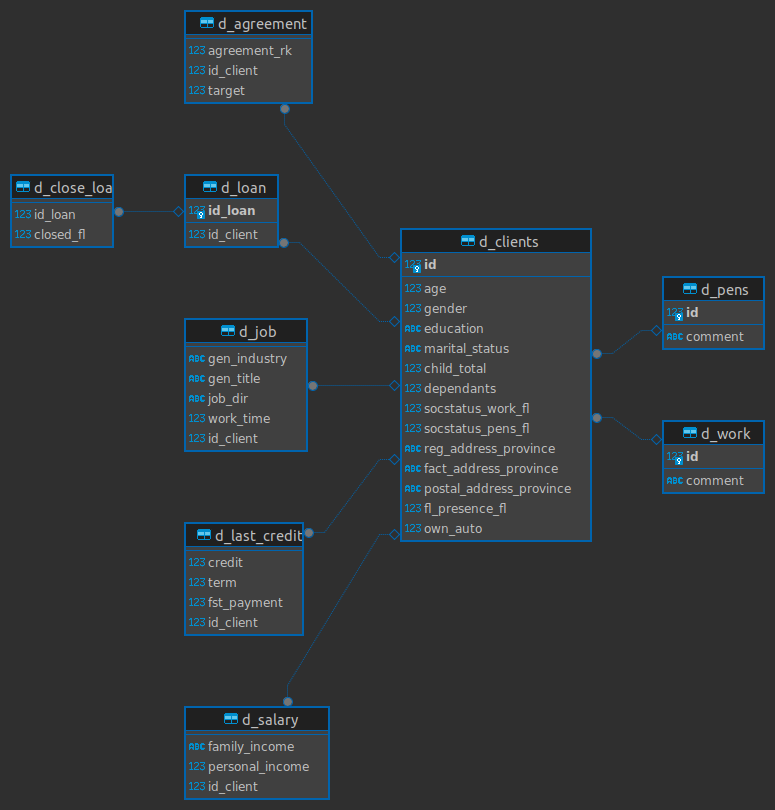

AGREEMENT_RK, TARGET, 
AGE, SOCSTATUS_WORK_FL, SOCSTATUS_PENS_FL, GENDER, CHILD_TOTAL, DEPENDANTS, 
PERSONAL_INCOME, 
LOAN_NUM_TOTAL, 
LOAN_NUM_CLOSED

# Сбор таблицы

Соберите датасет следующей структуры из данных, имеющихся в базе:


    - AGREEMENT_RK — уникальный идентификатор объекта в выборке;
    - TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);
    - AGE — возраст клиента;
    - SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);
    - SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
    - GENDER — пол клиента (1 — мужчина, 0 — женщина);
    - CHILD_TOTAL — количество детей клиента;
    - DEPENDANTS — количество иждивенцев клиента;
    - PERSONAL_INCOME — личный доход клиента (в рублях);
    - LOAN_NUM_TOTAL — количество ссуд клиента;
    - LOAN_NUM_CLOSED — количество погашенных ссуд клиента.

In [3]:

if __name__ == '__main__':
    conn = create_connection()
    if conn:
        with conn.cursor() as cursor:
            # sql для выполнения
            sql = 'SELECT agreement_rk FROM d_agreement'
            # выполнение запроса
            cursor.execute(sql)

            rows = cursor.fetchall()
            # потверждение выполнения запроса
            conn.commit()
        close_connection(conn)

Подключение к базе данных PostgreSQL прошло успешно
Соединение закрыто


In [4]:
# создаем коннект с базой
conn = psycopg2.connect(
            database="module_6",
            user='postgres',
            password='postgres',
            host='127.0.0.1',
            port='5433',
        )


In [5]:
# вытягиваем из БД табличку d_agreement
list_df = []
query_agr = """SELECT * FROM d_agreement"""
df_agr = pd.read_sql_query(query_agr, conn)
# приведем значения к типу int
col = df_agr.columns
df_agr = df_agr[col].astype(int)
list_df.append('df_agr') # чтобы что-то не забыть
df_agr

,agreement_rk,id_client,target
0,59910150,106804370,0
1,59910230,106804371,0
2,59910525,106804372,0
3,59910803,106804373,0
4,59911781,106804374,0
...,...,...,...
30441,75291424,106819588,0
30442,75291888,106819589,0
30443,75291923,106819590,0
30444,75291960,106819591,0


In [6]:
# сразу посмотрим вхождения целевой переменной
df_agr['target'].value_counts()

target
0    26822
1     3624
Name: count, dtype: int64

In [7]:
# вытягиваем данные из таблички d_clients

query_cli = """SELECT id AS id_client, age, socstatus_work_fl, socstatus_pens_fl, gender, child_total, dependants FROM d_clients"""

df_cli = pd.read_sql_query(query_cli, conn)
# приведем значения к типу int
col = df_cli.columns
df_cli = df_cli[col].astype(int)
list_df.append('df_cli')
df_cli

,id_client,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants
0,106805103,42,2,1,1,1,0
1,106809308,28,2,1,1,1,1
2,106805867,64,2,2,0,2,0
3,106808779,54,2,1,1,0,0
4,106814289,26,2,1,0,1,1
...,...,...,...,...,...,...,...
15995,106814680,26,2,1,1,1,1
15996,106812464,26,2,1,0,0,0
15997,106809255,30,2,1,1,0,0
15998,106814593,25,2,1,0,0,0


In [8]:
# вытягиваем данные из таблички d_salary

query_sal = """SELECT id_client, personal_income FROM d_salary"""
df_sal = pd.read_sql_query(query_sal, conn)
# приведем значения к типу int
col = df_sal.columns
df_sal = df_sal[col].astype(int)
list_df.append('df_sal')
df_sal

,id_client,personal_income
0,106809321,20000
1,106815561,14000
2,106811521,15000
3,106811252,20000
4,106808620,25000
...,...,...
31041,106812538,15000
31042,106814158,12000
31043,106805134,14000
31044,106812867,7000


In [9]:
# или так объеденим предыдущие запросы

query_un = """SELECT 
    a.*,
    c.id AS id_client, 
    c.age, 
    c.socstatus_work_fl, 
    c.socstatus_pens_fl, 
    c.gender, 
    c.child_total, 
    c.dependants, 
    s.personal_income
FROM 
    d_agreement a
LEFT JOIN 
    d_clients c ON a.id_client = c.id
LEFT JOIN 
    d_salary s ON c.id = s.id_client;"""
df_un = pd.read_sql_query(query_un, conn)
# приведем значения к типу int
col = df_un.columns
df_un = df_un[col].astype(int)
list_df.append('df_un')
df_un

,agreement_rk,id_client,id_client,target,id_client,id_client,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income
0,62246916,106809321,106809321,0,106809321,106809321,42,2,1,0,0,0,20000
1,62246916,106809321,106809321,0,106809321,106809321,42,2,1,0,0,0,20000
2,67011502,106815561,106815561,0,106815561,106815561,24,2,1,1,0,0,14000
3,67011502,106815561,106815561,0,106815561,106815561,24,2,1,1,0,0,14000
4,63918955,106811521,106811521,0,106811521,106811521,28,2,1,0,0,0,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62087,60104078,106805134,106805134,0,106805134,106805134,48,2,1,0,0,0,14000
62088,64893863,106812867,106812867,1,106812867,106812867,52,2,2,0,2,0,7000
62089,64893863,106812867,106812867,1,106812867,106812867,52,2,2,0,2,0,7000
62090,61847017,106808024,106808024,0,106808024,106808024,48,1,2,1,1,1,5200


In [10]:
df_agr.shape

(30446, 3)

In [11]:
df_cli.shape

(16000, 7)

In [12]:
# создаем loan_num_closed и	loan_num_total

query_loa = """select id_client, sum(closed_fl) as loan_num_closed, COUNT(id_loan) AS loan_num_total
from
(SELECT l.id_client, l.id_loan, cl.closed_fl
FROM d_close_loan AS cl
RIGHT JOIN d_loan AS l ON cl.id_loan = l.id_loan)
group by id_client"""

df_loa = pd.read_sql_query(query_loa, conn)
col = df_loa.columns
df_loa = df_loa[col].astype(int)
list_df.append('df_loa')
df_loa

,id_client,loan_num_closed,loan_num_total
0,106805226,0,2
1,106810338,0,2
2,106806653,0,2
3,106812841,0,2
4,106817686,0,4
...,...,...,...
15218,106812977,0,2
15219,106812052,0,2
15220,106811877,0,2
15221,106807782,0,2


In [13]:
print(df_agr['target'].value_counts())
print(df_un['target'].value_counts())

target
0    26822
1     3624
Name: count, dtype: int64
target
0    54680
1     7412
Name: count, dtype: int64


In [14]:
# сразу до объединения просмотрим и удалим дубликаты

print('agr', sum(df_agr.duplicated()), df_agr.shape)
print('cli', sum(df_cli.duplicated()), df_cli.shape)
print('sal', sum(df_sal.duplicated()), df_sal.shape)
print('loa', sum(df_loa.duplicated()), df_loa.shape)
print('un', sum(df_un.duplicated()), df_un.shape)

df_agr.drop_duplicates(inplace=True)
df_cli.drop_duplicates(inplace=True)
df_sal.drop_duplicates(inplace=True)
df_loa.drop_duplicates(inplace=True)
df_un.drop_duplicates(inplace=True)

print('before/after')
print('agr', sum(df_agr.duplicated()), df_agr.shape)
print('cli', sum(df_cli.duplicated()), df_cli.shape)
print('sal', sum(df_sal.duplicated()), df_sal.shape)
print('loa', sum(df_loa.duplicated()), df_loa.shape)
print('un', sum(df_un.duplicated()), df_un.shape)

agr 15223 (30446, 3)
cli 0 (16000, 7)
sal 15823 (31046, 2)
loa 0 (15223, 3)
un 46869 (62092, 13)
before/after
agr 0 (15223, 3)
cli 0 (16000, 7)
sal 0 (15223, 2)
loa 0 (15223, 3)
un 0 (15223, 13)


In [15]:
print(df_agr['target'].value_counts())
print(df_un['target'].value_counts())
list_df

target
0    13411
1     1812
Name: count, dtype: int64
target
0    13411
1     1812
Name: count, dtype: int64


['df_agr', 'df_cli', 'df_sal', 'df_un', 'df_loa']

In [16]:
# Соеденим все таблички
df_merged = pd.merge(df_agr, df_cli, on='id_client', how='left')
df_merged = pd.merge(df_merged, df_sal, on='id_client', how='inner')
df_merged = pd.merge(df_merged, df_loa, on='id_client', how='inner')

# и проконтролируем целевую переменную
print(df_agr['target'].value_counts())
print(df_un['target'].value_counts())
print(df_merged['target'].value_counts())
print('merged', sum(df_merged.duplicated()), df_merged.shape)

target
0    13411
1     1812
Name: count, dtype: int64
target
0    13411
1     1812
Name: count, dtype: int64
target
0    13411
1     1812
Name: count, dtype: int64
merged 0 (15223, 12)


In [17]:
df = df_merged
df.head()

,agreement_rk,id_client,target,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income,loan_num_closed,loan_num_total
0,59910150,106804370,0,49,2,1,1,2,1,5000,2,2
1,59910230,106804371,0,32,2,1,1,3,3,12000,2,2
2,59910525,106804372,0,52,2,1,1,4,0,9000,2,4
3,59910803,106804373,0,39,2,1,1,1,1,25000,2,2
4,59911781,106804374,0,30,2,1,0,0,0,12000,2,4


Будьте внимательны при сборке датасета: это реальные банковские данные, в которых могут наблюдаться дубли, некорректно заполненные значения или значения, противоречащие друг другу. Для получения качественной модели необходимо предварительно очистить датасет от такой информации.

In [18]:
# посмотрим пропущенные значения
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
missing_values

agreement_rk         0.0
id_client            0.0
target               0.0
age                  0.0
socstatus_work_fl    0.0
socstatus_pens_fl    0.0
gender               0.0
child_total          0.0
dependants           0.0
personal_income      0.0
loan_num_closed      0.0
loan_num_total       0.0
dtype: float64

In [19]:
df.columns

Index(['agreement_rk', 'id_client', 'target', 'age', 'socstatus_work_fl',
       'socstatus_pens_fl', 'gender', 'child_total', 'dependants',
       'personal_income', 'loan_num_closed', 'loan_num_total'],
      dtype='object')

In [20]:
# удалим коллонки с id
col_to_drop = ['agreement_rk', 'id_client']
df = df.drop(col_to_drop, axis=1)

In [21]:
df.columns

Index(['target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl', 'gender',
       'child_total', 'dependants', 'personal_income', 'loan_num_closed',
       'loan_num_total'],
      dtype='object')

In [22]:
# посмотрим статистики и значения

for i in df.columns:
    print(i)
    print(df[i].describe())
    print(df[i].value_counts())
    print('(:-)')

target
count    15223.000000
mean         0.119030
std          0.323835
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64
target
0    13411
1     1812
Name: count, dtype: int64
(:-)
age
count    15223.000000
mean        40.406096
std         11.601068
min         21.000000
25%         30.000000
50%         39.000000
75%         50.000000
max         67.000000
Name: age, dtype: float64
age
27    485
26    480
33    461
31    461
30    460
34    455
35    442
24    437
32    435
25    430
38    429
29    427
37    420
39    415
28    414
40    406
23    380
36    376
42    373
44    363
41    363
45    358
48    358
50    352
51    349
52    349
49    348
53    339
43    335
56    334
47    320
46    313
54    295
22    292
55    289
57    283
58    276
59    216
61    212
60    206
62    148
63    138
64    127
65     43
66     17
21     13
67      1
Name: count, dtype: int64
(:-)
socstatus_work_fl

socstatus_work_fl
2    13847
1     1376
Name: count, dtype: int64
(:-)
socstatus_pens_fl
count    15223.000000
mean         1.134468
std          0.341165
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: socstatus_pens_fl, dtype: float64
socstatus_pens_fl
1    13176
2     2047
Name: count, dtype: int64
(:-)
gender
count    15223.000000
mean         0.654536
std          0.475535
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64
gender
1    9964
0    5259
Name: count, dtype: int64
(:-)
child_total
count    15223.000000
mean         1.099389
std          0.995411
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: child_total, dtype: float64
child_total
1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: coun

In [23]:
df.to_csv('data/df.csv', index=False)

# Что нужно сделать после сбора таблицы:

In [24]:
# считать данные
df = pd.read_csv('data/df.csv')
# сохраним стартовый df для сравнения
df_start = pd.read_csv('data/df.csv')
print(df.shape)
df.head()

(15223, 10)


,target,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income,loan_num_closed,loan_num_total
0,0,49,2,1,1,2,1,5000,2,2
1,0,32,2,1,1,3,3,12000,2,2
2,0,52,2,1,1,4,0,9000,2,4
3,0,39,2,1,1,1,1,25000,2,2
4,0,30,2,1,0,0,0,12000,2,4


In [25]:
# посмотрим на количество дубликатов, появившихся после удаления id
# сразу их удалим
print('duplicated', sum(df.duplicated()), 'shape', df.shape)
# и проконтролируем целевую переменную
print(df['target'].value_counts())

# запишем в отдельный датафрейм получившиеся дубликаты
df_duplicated = df[df.duplicated()]

df.drop_duplicates(inplace=True)

print('-------')
print('before/after')
print('-------')
print('duplicated', sum(df.duplicated()), 'shape', df.shape)
print('df_target', df['target'].value_counts())
print('-------')
print('df_duplicates_target', df_duplicated['target'].value_counts())

duplicated 3301 shape (15223, 10)
target
0    13411
1     1812
Name: count, dtype: int64
-------
before/after
-------
duplicated 0 shape (11922, 10)
df_target target
0    10254
1     1668
Name: count, dtype: int64
-------
df_duplicates_target target
0    3157
1     144
Name: count, dtype: int64


In [26]:
for i in list(df):
    print('Характеристика:', i)
    print('type', df[i].dtype)
    print('Количество уникальных значений:', df[i].nunique())
    print(':-)')

Характеристика: target
type int64
Количество уникальных значений: 2
:-)
Характеристика: age
type int64
Количество уникальных значений: 47
:-)
Характеристика: socstatus_work_fl
type int64
Количество уникальных значений: 2
:-)
Характеристика: socstatus_pens_fl
type int64
Количество уникальных значений: 2
:-)
Характеристика: gender
type int64
Количество уникальных значений: 2
:-)
Характеристика: child_total
type int64
Количество уникальных значений: 10
:-)
Характеристика: dependants
type int64
Количество уникальных значений: 8
:-)
Характеристика: personal_income
type int64
Количество уникальных значений: 274
:-)
Характеристика: loan_num_closed
type int64
Количество уникальных значений: 10
:-)
Характеристика: loan_num_total
type int64
Количество уникальных значений: 9
:-)


Посмотрим на выбросы

In [27]:


def quantiles(df):
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75) # квантиль
    iqr = q75 - q25 #размах
    quantil_column = (int(q25 - 1.5 * iqr), int(q75 + 1.5 * iqr))

    return quantil_column



Вернувшись сюда посмотрим как относятся выбросы к таргету==1

In [28]:
# посмотрим количество выбросов с каждой стороны и выбросы в таргете == 1

more_2 = []
outliers = []

for i in list(df):
    quantil = quantiles(df[i])
    print(i, 'quantiles', quantil)
    print('значения min/max', min(df[i].values), max(df[i].values))
    print('количество значений', len(df[i].value_counts()))
    if len(df[i].value_counts()) > 2:
        more_2.append(i)
    is_outlier_right = sum(df[i] > quantil[1])
    is_outlier_left = sum(df[i] < quantil[0])
    if is_outlier_right != 0 or is_outlier_left != 0:
        outliers.append(i)
    print('left', is_outlier_left, 'right', is_outlier_right)
    print('-----rest------')
    sum_values = df[((df['target'] == '1') & (df[i] > quantil[1])) | ((df['target'] == '1') & (df[i] < quantil[0]))][i].sum()
    print('выбросы в таргете==1:', sum_values)
    print(':-)')

print(more_2)
print(outliers)


target quantiles (0, 0)
значения min/max 0 1
количество значений 2
left 0 right 1668
-----rest------
выбросы в таргете==1: 0
:-)
age quantiles (3, 79)
значения min/max 21 67
количество значений 47
left 0 right 0
-----rest------
выбросы в таргете==1: 0
:-)
socstatus_work_fl quantiles (2, 2)
значения min/max 1 2
количество значений 2
left 1238 right 0
-----rest------
выбросы в таргете==1: 0
:-)
socstatus_pens_fl quantiles (1, 1)
значения min/max 1 2
количество значений 2
left 0 right 1880
-----rest------
выбросы в таргете==1: 0
:-)
gender quantiles (-1, 2)
значения min/max 0 1
количество значений 2
left 0 right 0
-----rest------
выбросы в таргете==1: 0
:-)
child_total quantiles (-3, 5)
значения min/max 0 10
количество значений 10


left 0 right 21
-----rest------
выбросы в таргете==1: 0
:-)
dependants quantiles (-1, 2)
значения min/max 0 7
количество значений 8
left 0 right 288
-----rest------
выбросы в таргете==1: 0
:-)
personal_income quantiles (-5500, 30500)
значения min/max 24 250000
количество значений 274
left 0 right 463
-----rest------
выбросы в таргете==1: 0
:-)
loan_num_closed quantiles (-3, 5)
значения min/max 0 22
количество значений 10
left 0 right 875
-----rest------
выбросы в таргете==1: 0
:-)
loan_num_total quantiles (-1, 7)
значения min/max 2 22
количество значений 9
left 0 right 427
-----rest------
выбросы в таргете==1: 0
:-)
['age', 'child_total', 'dependants', 'personal_income', 'loan_num_closed', 'loan_num_total']
['target', 'socstatus_work_fl', 'socstatus_pens_fl', 'child_total', 'dependants', 'personal_income', 'loan_num_closed', 'loan_num_total']


# Удаляем выбросы для всех колонок (кроме target)
for i in df.columns:
    quantil = quantiles(df[i])
    if i != 'target':  # Проверяем, чтобы не работать с колонкой 'target'
        mask = ((df['target'] != '1') & ((df[i] < quantil[0]) | (df[i] > quantil[1])))
        #df = df[~mask]

# как показала практика с выбросами не будем делать НИЧЕГО

##### функция на память

заменим значения выбросов на граничные квантильного размаха:

outliers = ['loan_num_closed', 'loan_num_total']

for i in outliers:
    quantil = quantiles(df[i])
    df[i] = np.where(df[i] > quantil[1], quantil[1], df[i])
    is_outlier_right = sum(df[i] > quantil[1])
    is_outlier_left = sum(df[i] < quantil[0])

    print(i, 'left', is_outlier_left, 'right', is_outlier_right)

In [29]:
# переведем в категории min medium max (1, 2, 3)

to_category = ['age', 'child_total', 'dependants'] #, 'personal_income']

for i in to_category:
    print('значения min/max', min(df[i].values), max(df[i].values))
    thrid = (max(df[i].values) - min(df[i].values)) / 3
    a = min(df[i].values) + thrid
    b = min(df[i].values) + (thrid * 2)
    df[i] = np.where(df[i] < a, 1, df[i])
    df[i] = np.where((df[i] >= a) & (df[i] <= b), 2, df[i])
    df[i] = np.where(df[i] > b, 3, df[i])
    #print(a, b)
    print(df[i].value_counts())
    #print(min(df[i].values) * 1.6)
    print('(:-)')

значения min/max 21 67
age
2    4545
1    4451
3    2926
Name: count, dtype: int64
(:-)
значения min/max 0 10
child_total
1    11709
2      204
3        9
Name: count, dtype: int64
(:-)
значения min/max 0 7


dependants
1    11634
2      278
3       10
Name: count, dtype: int64
(:-)


In [30]:
df.corr()

,target,age,socstatus_work_fl,socstatus_pens_fl,gender,child_total,dependants,personal_income,loan_num_closed,loan_num_total
target,1.000000,-0.132913,0.096867,-0.108827,-0.023425,0.006773,0.034918,0.090496,-0.087007,-0.059313
age,-0.132913,1.000000,-0.427369,0.546346,0.148878,0.098651,-0.068219,-0.103399,-0.040124,-0.027180
socstatus_work_fl,0.096867,-0.427369,1.000000,-0.786728,-0.106758,-0.082001,0.040794,0.204865,0.060165,0.056546
socstatus_pens_fl,-0.108827,0.546346,-0.786728,1.000000,0.143277,0.099800,-0.052751,-0.146345,-0.044006,-0.034323
gender,-0.023425,0.148878,-0.106758,0.143277,1.000000,0.023200,-0.037996,-0.219033,0.014492,0.020346
child_total,0.006773,0.098651,-0.082001,0.099800,0.023200,1.000000,0.230749,-0.036457,-0.027773,-0.016513
dependants,0.034918,-0.068219,0.040794,-0.052751,-0.037996,0.230749,1.000000,0.004005,-0.024844,-0.016534
personal_income,0.090496,-0.103399,0.204865,-0.146345,-0.219033,-0.036457,0.004005,1.000000,-0.036251,-0.050101
loan_num_closed,-0.087007,-0.040124,0.060165,-0.044006,0.014492,-0.027773,-0.024844,-0.036251,1.000000,0.870084
loan_num_total,-0.059313,-0.027180,0.056546,-0.034323,0.020346,-0.016513,-0.016534,-0.050101,0.870084,1.000000


In [31]:
# корреляции сразу посмотрим

col_min_corr = []
for i in df.columns:
    j = df[i]
    corr = df['target'].corr(j)
    if -0.001 < corr and corr < 0.001:
        col_min_corr.append(i)


    print('corr', i, round(df['target'].corr(j), 6))

print('min_corr', col_min_corr)

corr target 1.0


corr age -0.132913
corr socstatus_work_fl 0.096867
corr socstatus_pens_fl -0.108827
corr gender -0.023425
corr child_total 0.006773
corr dependants 0.034918
corr personal_income 0.090496
corr loan_num_closed -0.087007
corr loan_num_total -0.059313
min_corr []


In [32]:
# сравним корреляции с неизмененным df_start

col_min_corr = []
for i in df_start.columns:
    j = df_start[i]
    corr = df_start['target'].corr(j)
    if -0.001 < corr and corr < 0.001:
        col_min_corr.append(i)


    print('corr', i, round(df_start['target'].corr(j), 6))

print('min_corr', col_min_corr)
#print(outliers, to_category)

corr target 1.0
corr age -0.103868
corr socstatus_work_fl 0.078377
corr socstatus_pens_fl -0.084826
corr gender -0.030723
corr child_total 0.011598
corr dependants 0.05217
corr personal_income 0.094575


corr loan_num_closed -0.062475
corr loan_num_total -0.03314
min_corr []


### Исследования и графики

проведите анализ данных, посмотрите на индивидуальные графики

зависимости целевой функции и отдельной переменной

создайте дополнительные переменные

для работы с категориальными данными можно воспользоваться pd.get_dummies

сделайте предварительные выводы

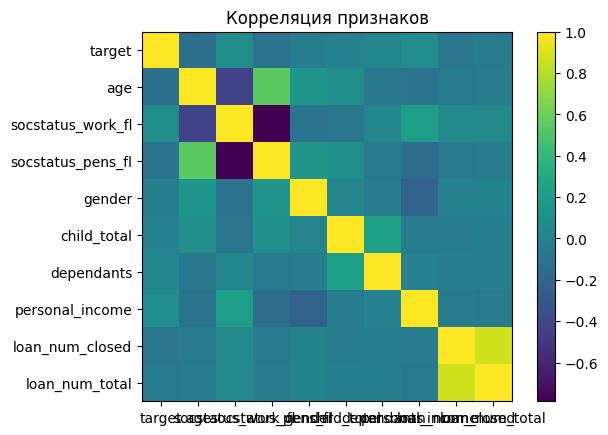

In [33]:


columns = df.corr().columns.tolist()
plt.imshow(df.corr())

plt.title("Корреляция признаков")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

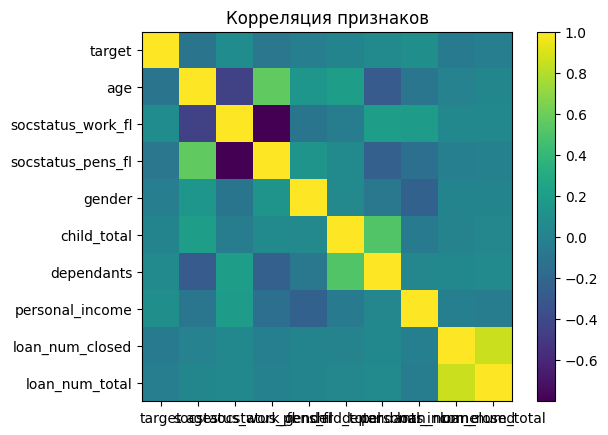

In [34]:
columns = df_start.corr().columns.tolist()
plt.imshow(df_start.corr())

plt.title("Корреляция признаков")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

<Axes: >

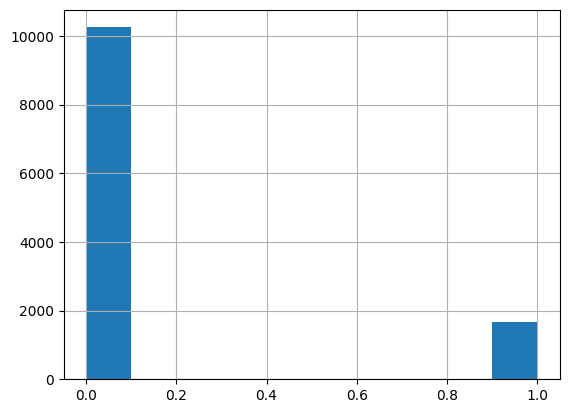

In [35]:
df['target'].hist()

In [36]:
df.columns

Index(['target', 'age', 'socstatus_work_fl', 'socstatus_pens_fl', 'gender',
       'child_total', 'dependants', 'personal_income', 'loan_num_closed',
       'loan_num_total'],
      dtype='object')

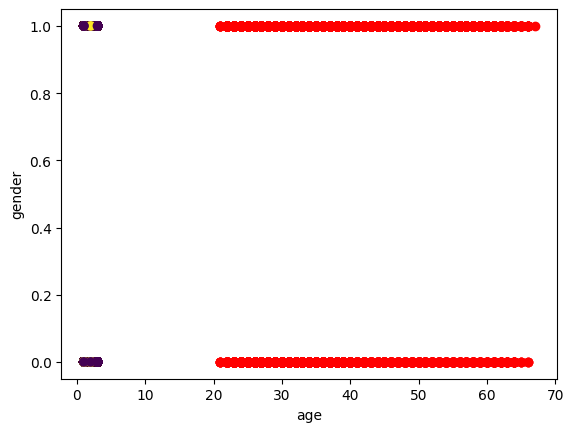

In [37]:
# Сравним два датасета, изначальный и категориальный

x1 = 'age'
x2 = 'gender'
plt.scatter(df[x1], df[x2], c=df['target'])
plt.scatter(df_start[x1], df_start[x2], c='red')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

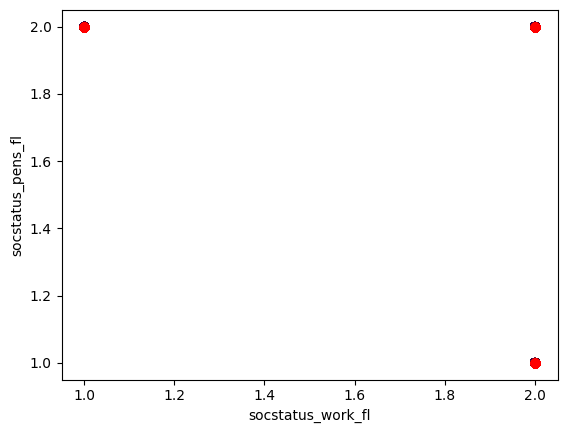

In [38]:
x1 = 'socstatus_work_fl'
x2 = 'socstatus_pens_fl'
plt.scatter(df[x1], df[x2], c=df['target'])
plt.scatter(df_start[x1], df_start[x2], c='red')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

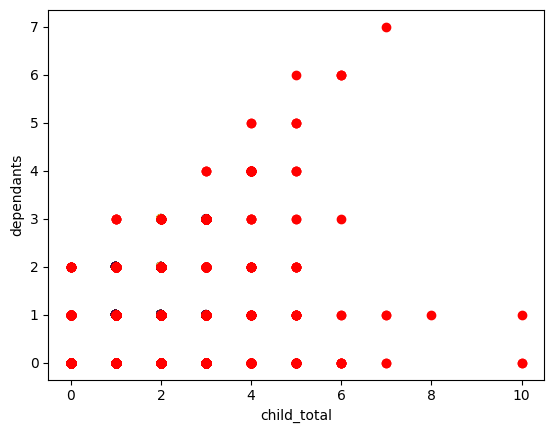

In [39]:
x1 = 'child_total'
x2 = 'dependants'
plt.scatter(df[x1], df[x2], c=df['target'])
plt.scatter(df_start[x1], df_start[x2], c='red')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

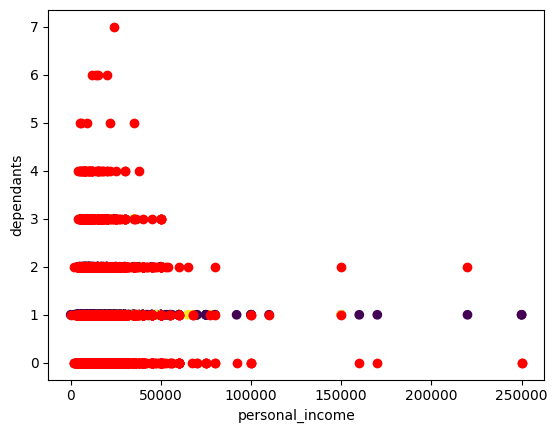

In [40]:
x1 = 'personal_income'
x2 = 'dependants'
plt.scatter(df[x1], df[x2], c=df['target'])
plt.scatter(df_start[x1], df_start[x2], c='red')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

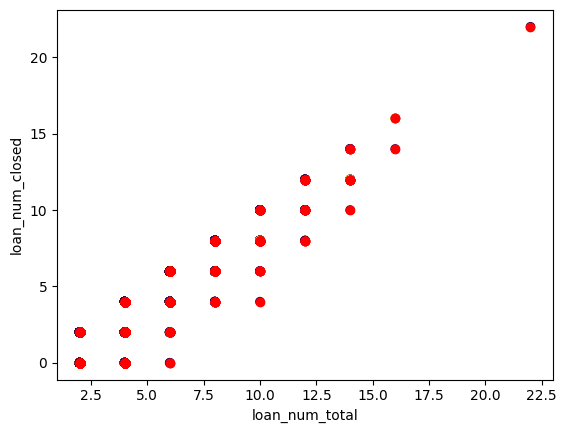

In [41]:
x1 = 'loan_num_total'
x2 = 'loan_num_closed'
plt.scatter(df[x1], df[x2], c=df['target'])
plt.scatter(df_start[x1], df_start[x2], c='red')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

In [83]:
# раздедлите на обучающую и тестовую выборки

X = df.drop(['target'], axis=1)
y = df['target']

X_dum = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, random_state=42)

In [84]:
# Взвешивание объектов

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [85]:
# обучите модель методом ближайших соседей

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [80]:
# очень интересно посмотреть на предварительные результаты

print('Прогнозы для обучающей выборки:', knn.predict(X_train))
print('Точность для обучающей выборки:', knn.score(X_train, y_train))
print('Точность для тестовой выборки:', knn.score(X_test, y_test))

Прогнозы для обучающей выборки: [0 0 0 ... 0 0 0]
Точность для обучающей выборки: 0.8715398442180947
Точность для тестовой выборки: 0.8297455968688845


In [46]:
score_list = []
for k in range(1, 10, 2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  score_train = knn.score(X_train, y_train)
  score_test = knn.score(X_test, y_test)

  score_list.append([k, score_train, score_test])


In [47]:
score_df = pd.DataFrame(score_list, columns= ['k', 'score_train', 'score_test'])
score_df.head()

,k,score_train,score_test
0,1,0.825404,0.777467
1,3,0.839305,0.815767
2,5,0.843739,0.831143
3,7,0.854404,0.852949
4,9,0.858478,0.857422


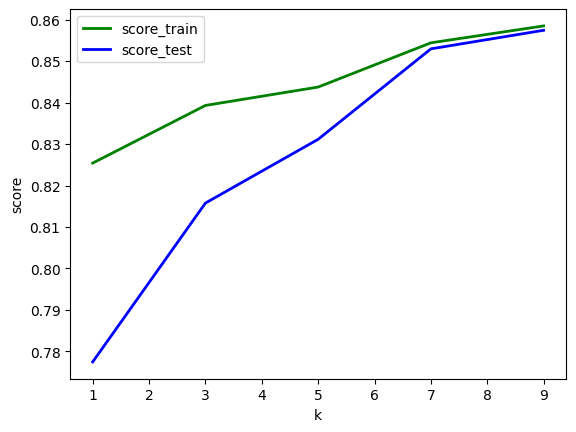

In [48]:
plt.plot(score_df['k'], score_df['score_train'], linewidth = 2, color='g', label='score_train')
plt.plot(score_df['k'], score_df['score_test'], linewidth = 2, color='b', label='score_test')

plt.xlabel('k')
plt.ylabel('score')
plt.legend(loc='best')
plt.show()

In [49]:
score_df[score_df['score_test'] == max(score_df['score_test'])]

,k,score_train,score_test
4,9,0.858478,0.857422


проверьте качество модели с помощью F-мера

In [86]:
y_pred = knn.predict(X_test)

In [51]:
# проверим данные
print(np.unique(y_test))
print(len(y_test), len(y_pred))

[0 1]
3577 3577


In [87]:
# Вычисление F-меры

unique_classes = np.unique(y_test)
res = classification_report(y_test, y_pred, target_names=[str(c) for c in unique_classes])
print(res)


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3072
           1       0.21      0.13      0.16       505

    accuracy                           0.81      3577
   macro avg       0.54      0.53      0.53      3577
weighted avg       0.77      0.81      0.79      3577



проверьте качество модели с помощью матрицы сопряжённостей

In [89]:
predicted_train = knn.predict(X_train)
predicted_test = knn.predict(X_test)

confusion_matrix(y_test, predicted_test)

array([[2831,  241],
       [ 440,   65]])

# Подобор оптимального числа ближайших соседей методом leave-one-out

In [67]:
# Настройка leave-one-out

# Загрузка данных
X = df_duplicated.drop(['target'], axis=1) 
y = df_duplicated['target']

loo = LeaveOneOut()
k_values = range(1, 6)  # Проверка k
accuracies = []

In [68]:
# проверим индексы loo.split(X):

for train_index, test_index in loo.split(X):
    print("Train indices:", train_index)
    print("Test indices:", test_index)


Train indices: [   1    2    3 ... 3298 3299 3300]
Test indices: [0]
Train indices: [   0    2    3 ... 3298 3299 3300]
Test indices: [1]
Train indices: [   0    1    3 ... 3298 3299 3300]
Test indices: [2]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [3]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [4]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [5]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [6]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [7]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [8]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [9]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [10]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [11]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [12]
Train indices: [   0    1    2 ... 3298 3299 3300]
Test indices: [13]
Train indices: [   0    1    2

In [71]:
# Для каждого значения k
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    predictions = []
    
    # Leave-One-Out валидация
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        predictions.append(prediction[0])
    
    # Считаем точность
    accuracy = accuracy_score(y, predictions)
    accuracies.append(accuracy)

In [72]:


# Определяем оптимальное k
optimal_k = k_values[np.argmax(accuracies)]
print(f"Оптимальное значение k: {optimal_k}")

Оптимальное значение k: 2


In [88]:
to_category

['age', 'child_total', 'dependants']

    # сделайте вывод о работе модели

1. Выбросы. По итогам работы с выбросами, как это не парадоксально звучит, отказался от этой затеи, поскольку в выбросы попадает меньший класс при дисбалансе классов. При замене выбросов на граничные значения квантильного размаха качество модели снизилось.

2. Категоризировал ['age', 'child_total', 'dependants'] численные категории - 1, 2, 3. это немного улучшило качество модели.

3. Подобор оптимального числа ближайших соседей методом leave-one-out выдал - 2, однако при перборе вручную, методом 'научного тыка', пришел к тому, что при выборе 3-х соседей качество модели на таргете==1 лучше.

4. Качество модели на мой взгляд достаточно печальное, но я предполагаю что надежды есть

In [90]:
print(res)
confusion_matrix(y_test, predicted_test)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3072
           1       0.21      0.13      0.16       505

    accuracy                           0.81      3577
   macro avg       0.54      0.53      0.53      3577
weighted avg       0.77      0.81      0.79      3577



array([[2831,  241],
       [ 440,   65]])